In [1]:
import os
import sys
sys.path.append(os.getcwd()+"/../..")
from src import paths

from sklearn.metrics import classification_report
from src.utils import plot_confusion_matrix, line_label_id2label, line_Label_label2id, performance_metrics, plot_embeddings, get_df_classificationreport

import torch

# MedBERT Finetune on Lines

In [11]:
results = torch.load(paths.RESULTS_PATH/"line-label"/"line-label_medbert-512_class_finetuned_test.pt")
labels = results["labels"]
last_hidden_state = results["last_hidden_state"] # If inference was run without --output_hidden_states, this will be None and no plottings will be possible
preds = results["preds"]

In [12]:
# Last hidden stats is list of tensors, each tensor is (seq_len, hidden_size). Will take CLS token
cls_tokens = [tensor[0,:] for tensor in last_hidden_state]

embeddings = torch.stack(cls_tokens, dim = 0)

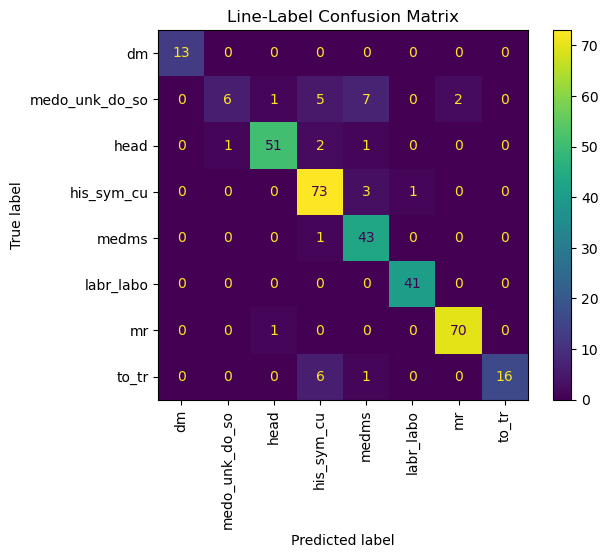

In [13]:
plot_confusion_matrix(preds=preds, labels=labels, title="Line-Label Confusion Matrix", label2id=line_Label_label2id)

In [5]:
y_valid = [line_label_id2label[label] for label in labels]
y_pred = [line_label_id2label[pred] for pred in preds]
get_df_classificationreport(y_valid, y_pred, labels = sorted(line_label_id2label.values())).round(2)

,eval_measure,precision,recall,f1-score,support
0,dm,1.00,1.00,1.00,13
1,head,0.96,0.93,0.94,55
2,his_sym_cu,0.84,0.95,0.89,77
3,labr_labo,0.98,1.00,0.99,41
4,medms,0.78,0.98,0.87,44
5,medo_unk_do_so,0.86,0.29,0.43,21
6,mr,0.97,0.99,0.98,71
7,to_tr,1.00,0.70,0.82,23
8,accuracy,NaN,NaN,0.91,345
9,macro avg,0.92,0.85,0.86,345


(345, 2)


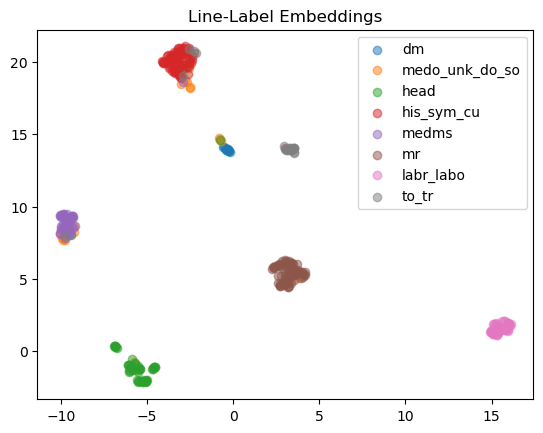

In [6]:
plot_embeddings(embeddings, [line_label_id2label[label] for label in labels], title="Line-Label Embeddings", method="umap", )

# MedBERT Token Classification

In [7]:
results = torch.load(paths.RESULTS_PATH/"line-label/line-label_medbert-512_token_finetuned_test.pt")

In [8]:
labels, preds = [], []
for obs in results:
    labels.extend(obs["labs"])
    preds.extend(obs["preds"])

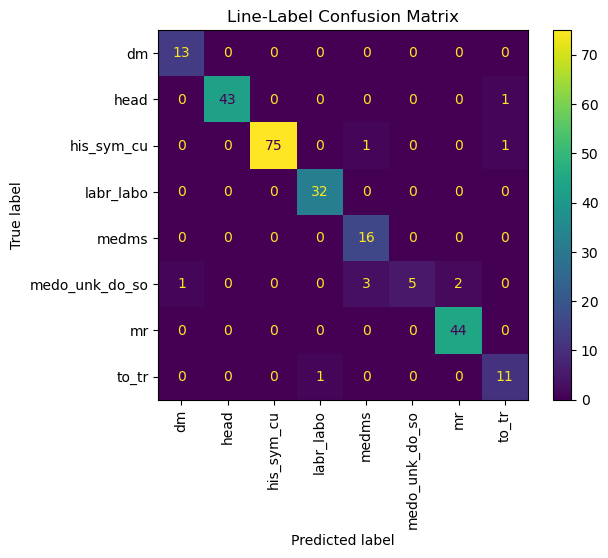

In [9]:
plot_confusion_matrix(preds=preds, labels=labels, title="Line-Label Confusion Matrix")

In [10]:
get_df_classificationreport(labels, preds, labels = sorted(line_label_id2label.values())).round(2)

,eval_measure,precision,recall,f1-score,support
0,dm,0.93,1.00,0.96,13
1,head,1.00,0.98,0.99,44
2,his_sym_cu,1.00,0.97,0.99,77
3,labr_labo,0.97,1.00,0.98,32
4,medms,0.80,1.00,0.89,16
5,medo_unk_do_so,1.00,0.45,0.62,11
6,mr,0.96,1.00,0.98,44
7,to_tr,0.85,0.92,0.88,12
8,accuracy,NaN,NaN,0.96,249
9,macro avg,0.94,0.92,0.91,249
